## Question 1: Create Pandas Dataframe with Toronto Neighborhood Data

In [1]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import json 

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

import requests 
from pandas.io.json import json_normalize 

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    certifi-2020.4.5.2         |   py36h9f0ad1d_0         152 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2020.4.5.2 |       hecda079_0         147 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0           conda-forge
    geopy:          

In [2]:
# Read data from website using Pandas
dta = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
Toronto = pd.DataFrame(dta[0])
Toronto.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [3]:
# Drop Rows with Borough = "Not Assigned"
Toronto = Toronto[Toronto.Borough != "Not assigned"]
Toronto.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [4]:
# If Neighborhood is "Not assigned" then set it to the name of the Borough
Toronto['Neighborhood'] = np.where(Toronto['Neighborhood'] == 'Not assigned', Toronto['Borough'], Toronto['Neighborhood'])
Toronto.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [5]:
# Make sure that there are not multiple instances of Postal Code
# If the number of unique postal codes = number of total postal codes then there are no duplicates 
print(len(Toronto))
print(len(Toronto.groupby('Postal Code')))

103
103


In [6]:
# Use shape to print number of rows
Toronto.shape[0]

103

## Question 2: Add Latitude and Longitude Data to Neighborhood Dataframe

In [7]:
# Import CSV file with latitude and longitude
lat_long = pd.read_csv('https://cocl.us/Geospatial_data')
lat_long.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [8]:
# Sort both dataframes on Postal Code
Toronto = Toronto.sort_values(by = 'Postal Code')
lat_long = lat_long.sort_values(by = 'Postal Code')

# Add lattitude and longitude data to Neighborhood data
Tor_Loc = pd.merge(Toronto, lat_long, how = 'left', on = 'Postal Code')
print(Tor_Loc.shape[0])
Tor_Loc.head(12)

103


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


## Question 3: Cluster Neighborhoods 

In [9]:
# Subset data to only include Toronto Neighborhoods
TorNeigh = Tor_Loc[Tor_Loc['Borough'].str.contains('Toronto')]
print(TorNeigh.shape[0])
TorNeigh.head()

39


,Postal Code,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [13]:
# Create a map of the neighborhoods in Toronto
map_toronto = folium.Map(location = [43.6529, -79.3849], zoom_start = 12)

# add markers to map
for lat, lng, borough, neighborhood in zip(TorNeigh['Latitude'], TorNeigh['Longitude'], TorNeigh['Borough'], TorNeigh['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_toronto)  
    
map_toronto

In [14]:
# Define Connection Variables for Foursquare
CLIENT_ID = 'BUXQS3K2GMRX5RGZDRC3ZZHXR4TEESY2ERQPL2LYW2TF45RH' 
CLIENT_SECRET = 'FYBGH3XZ3IRG4LZQVINHNQB3YUNOGWLMMJTCLY1IKGCEN5Z1' 
VERSION = '20180605'

Your credentails:
CLIENT_ID: BUXQS3K2GMRX5RGZDRC3ZZHXR4TEESY2ERQPL2LYW2TF45RH
CLIENT_SECRET:FYBGH3XZ3IRG4LZQVINHNQB3YUNOGWLMMJTCLY1IKGCEN5Z1


In [17]:
# Create a function to retrieve venues in each neighborhood
def getNearbyVenues(names, latitudes, longitudes, radius = 500, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
# Create a dataframe with venues for each neighborhood
toronto_venues = getNearbyVenues(names = TorNeigh['Neighborhood'],
                                   latitudes = TorNeigh['Latitude'],
                                   longitudes = TorNeigh['Longitude'],
                                   LIMIT = 100
                                  )

toronto_venues.head()

The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West, Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High 

In [20]:
# Determine top venues for each neighborhood
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix = "", prefix_sep = "")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

# Group by neighborhood
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

In [21]:
# Create a function to sort most common venues by descending
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [56]:
# Create a dataframe with the top 10 venues for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns = columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Seafood Restaurant,Cheese Shop,Beer Bar,Bakery,Café,Restaurant,Eastern European Restaurant,Department Store
1,"Brockton, Parkdale Village, Exhibition Place",Café,Bakery,Breakfast Spot,Coffee Shop,Gym,Grocery Store,Pet Store,Performing Arts Venue,Nightclub,Italian Restaurant
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Yoga Studio,Auto Workshop,Gym / Fitness Center,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Comic Shop,Pizza Place
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Bar,Harbor / Marina,Coffee Shop,Boat or Ferry,Rental Car Location,Boutique,Plane
4,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Burger Joint,Japanese Restaurant,Department Store,Salad Place,Bubble Tea Shop,Yoga Studio


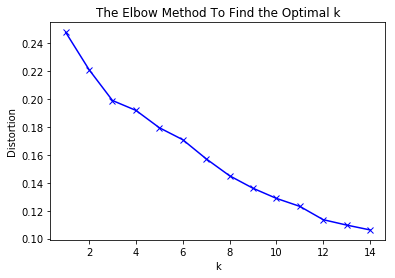

In [40]:
# Determine how many clusters to use for k-means

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
distortions = []
K = range(1,15)

for k in K:
    kmeanModel = KMeans(n_clusters = k, random_state = 0).fit(toronto_grouped_clustering)
    kmeanModel.fit(toronto_grouped_clustering)
    distortions.append(sum(np.min(cdist(toronto_grouped_clustering, 
                                        kmeanModel.cluster_centers_, 
                                        'euclidean'), axis = 1)) / toronto_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method To Find the Optimal k')
plt.show()

In [43]:
# set number of clusters based on elbow method - it looks like 3 is best for this data
kclusters = 3
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(toronto_grouped_clustering)

# Check clusters
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [51]:
# The clusters are not very even, 12 looks like another elbow point for this data
kclusters = 12
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(toronto_grouped_clustering)

# Check clusters
kmeans.labels_

array([ 1,  1,  1, 11,  1,  6,  1,  1,  1,  5,  9,  1,  3,  1,  1,  1,  1,
        1,  7,  1, 10,  1,  8,  1,  1,  1,  4,  2,  1,  1,  1,  1,  1,  1,
        1,  0,  1,  1,  1], dtype=int32)

In [57]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = TorNeigh

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on = 'Neighborhood')

toronto_merged.head() 

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Trail,Pub,Health Food Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Women's Store
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,1,Greek Restaurant,Italian Restaurant,Coffee Shop,Furniture / Home Store,Restaurant,Bookstore,Ice Cream Shop,Caribbean Restaurant,Pub,Lounge
42,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,1,Park,Fast Food Restaurant,Gym,Ice Cream Shop,Fish & Chips Shop,Steakhouse,Restaurant,Pub,Italian Restaurant,Burrito Place
43,M4M,East Toronto,Studio District,43.659526,-79.340923,1,Café,Coffee Shop,Bakery,Gastropub,American Restaurant,Brewery,Latin American Restaurant,Bar,Ice Cream Shop,Fish Market
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,7,Park,Swim School,Bus Line,Dessert Shop,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


In [58]:
# Map the clustered neighborhoods
latitude = 43.6529
longitude =  -79.3849
map_clusters = folium.Map(location = [latitude, longitude], zoom_start = 12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[cluster-1],
        fill = True,
        fill_color = rainbow[cluster-1],
        fill_opacity = 0.7).add_to(map_clusters)
       
map_clusters

### The neighborhoods in Toronto overall seem pretty similar with a few outiers.  Using 12 clusters instead of 3 show the neighborhoods that are different than the majority of Toronto neighborhoods